In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['legend.fontsize'] = 'large'

In [2]:
dffull = pd.read_csv('../data/religion.csv')
dffull.head()

,promney,rfrac
0,0.047790,0.00
1,0.051199,0.01
2,0.054799,0.02
3,0.058596,0.03
4,0.062597,0.04


In [3]:
x=dffull.rfrac.values
f=dffull.promney.values

In [6]:
df = pd.read_csv("../data/noisysample.csv")
df.head()

,x,f,y,i
0,0.04,0.062597,0.036211,4
1,0.11,0.096800,0.194625,11
2,0.16,0.128537,0.072212,16
3,0.18,0.143061,0.109693,18
4,0.27,0.221640,0.413717,27


In [9]:
from sklearn.model_selection import train_test_split
datasize=df.shape[0]
#split dataset using the index, as we have x,f, and y that we want to split.
itrain,itest = train_test_split(range(30),train_size=24, test_size=6)
xtrain= df.x[itrain].values
ftrain = df.f[itrain].values
ytrain = df.y[itrain].values
xtest= df.x[itest].values
ftest = df.f[itest].values
ytest = df.y[itest].values

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [11]:
def make_features(train_set, test_set, degrees):
    traintestlist=[]
    for d in degrees:
        traintestdict={}
        traintestdict['train'] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        traintestdict['test'] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        traintestlist.append(traintestdict)
    return traintestlist
degrees=range(21)
traintestlists=make_features(xtrain, xtest, degrees)

# Constraining parameters by penalty

We have focused on finding the polynomial with the right degree of complexity $d^*$

Now we have another question: give a degree, say 20, how can we **regularize** or smooth, or restrict the choises of the kinds of the 20th order polynomials that we allows in our fit. In other words, we are again trying to bring down the complexiity of the hypothesis space, but using different strategy: **preferring smooth polynomials over wiggly ones**.

We do this by a **soft constraint** by setting: $$\sum_{i=0}^{j}a_i^2 < C$$

This setting is called the **ridge**.

This ensures that the coeffcient don't get too high. Hence ''smoothing''. 

If we set $$\sum_{i=0}^{j}|a_i| < C,$$ it can be shown that some coefficients will be set exactly 0. This is called the Lasso. 

How do we incorporate the constraints then? We do this by adding it to the empirical risk 

$$R(h_j) = \sum (y_i - h_j(x_i))^2 + \alpha \sum a_i^2$$

To find optimal $\alpha$ we can invoke the same validation and cross-validation technology that we developed to estimate d.

The technique is called **regularization** or **shrinkage** as it takes the coefficients $a_i$ towards smaller sizes. 

The problem with a non-zero $\apha$ is called **ridge regression**. As $\apha$ increases, the importance of the penalty term increases at the expense of the ERM term, and we are pushed

# A toy example

(100, 3)


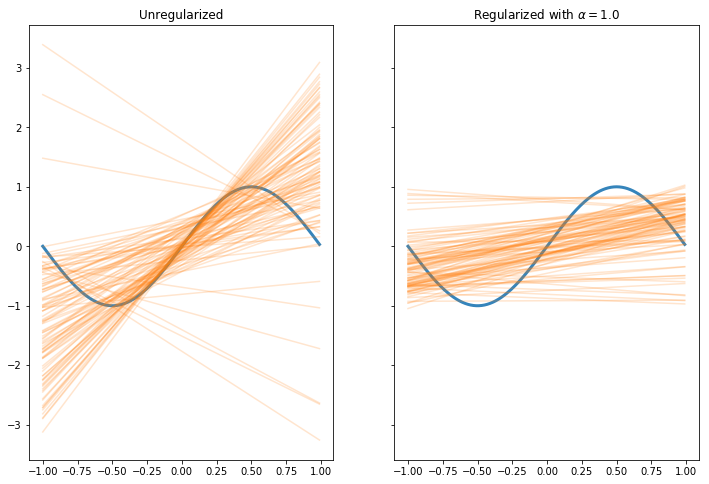

In [26]:
xs=np.arange(-1.,1.,0.01)
ff = lambda x: np.sin(np.pi*x)
ffxs=ff(xs)
fig, axes = plt.subplots(1,2, sharey=True)
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
axes[0].plot(xs, ff(xs), alpha=0.9, lw=3, color=c0)
axes[1].plot(xs, ff(xs), alpha=0.9, lw=3, color=c0)

from sklearn.linear_model import Ridge
D=np.empty((100,3), dtype="int")
print(D.shape)
for i in range(100):
    D[i,:] = np.random.choice(200, replace=False, size=3)
for i in range(100):
    choices = D[i,:]
    #regular fit
    p1=np.polyfit(xs[choices], ffxs[choices],1)
    #ridge fit
    est = Ridge(alpha=1)
    est.fit(xs[choices].reshape(-1,1), ffxs[choices])
    axes[0].plot(xs, np.polyval(p1, xs), color=c1, alpha=0.2)
    axes[1].plot(xs, est.predict(xs.reshape(-1,1)), color=c1, alpha=0.2)
axes[0].set_title("Unregularized");
axes[1].set_title("Regularized with $\\alpha=1.0$");

## Regularization of the Romney model with cross-validation

In [27]:
def plot_functions(est, ax, df, alpha, xtest, Xtest, xtrain, ytrain):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', label="training", alpha=0.4)
    ax.plot(xtest, ytest, 's', label="testing", alpha=0.6)
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX),  '.', label="alpha = %s" % str(alpha))
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')
    
def plot_coefficients(est, ax, alpha):
    coef = est.coef_.ravel()
    ax.semilogy(np.abs(coef), marker='o', label="alpha = %s" % str(alpha))
    ax.set_ylim((1e-1, 1e15))
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.legend(loc='upper left')

The effect of regularization is illustrated as in the following diagram.

![regualization](gfx/complexity-error-reg.png)

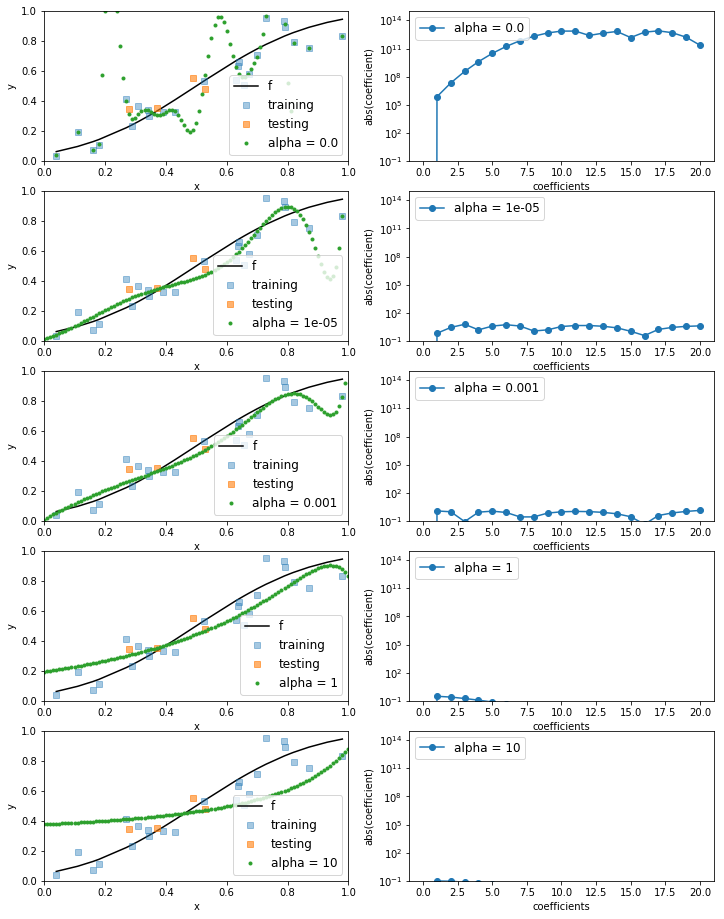

In [31]:
fig, rows = plt.subplots(5, 2, figsize=(12, 16))
d=20
alphas = [0.0, 1e-5, 1e-3, 1, 10]
Xtrain = traintestlists[d]['train']
Xtest = traintestlists[d]['test']
for i, alpha in enumerate(alphas):
    l,r=rows[i]
    est = Ridge(alpha=alpha)
    est.fit(Xtrain, ytrain)
    plot_functions(est, l, df, alpha, xtest, Xtest, xtrain, ytrain )
    plot_coefficients(est, r, alpha)